Using TensorFlow backend.


(50000, 28, 28) (50000,)


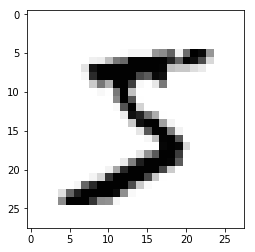

In [1]:
from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
print(X_train.shape, y_train.shape)
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X_train[0], cmap="Greys");

In [ ]:
import tensorflow as tf
import numpy as np

NUM_OF_CATEGORY = 10
NUM_OF_NEURON_L1 = 300
NUM_OF_DENSE_L = 50

LEARNING_RATE = 0.01
NUM_OF_EPOCH = 200
BATCH_SIZE = 100
REG_LAMBDA = 0.00001

def reshape_X(X):
    return np.reshape(X, [X.shape[0], X.shape[1] * X.shape[2]])

def one_hot_encoding(Y):
    result = np.zeros((Y.shape[0], 10))
    for i in range(Y.shape[0]):
        y = Y[i]
        result[i][y] = 1.0
    return result

# Shuffle the data of X_train and y_train to make it random

from sklearn.utils import shuffle

shuffled_X_train, shuffled_Y_train = shuffle(X_train, y_train, random_state=0)

# reshaped the X data to a 1-D array
X_train_reshaped = reshape_X(shuffled_X_train)
X_val_reshaped = reshape_X(X_val)
X_test_reshaped = reshape_X(X_test)

# one hot encoding the val and test label
y_val_reshaped = one_hot_encoding(y_val)
y_test_reshaped = one_hot_encoding(y_test)

layer1_input_count = X_train_reshaped.shape[1]
num_of_batch = int(X_train_reshaped.shape[0]/BATCH_SIZE)

# construct the forward propagation

input_X = tf.placeholder('float32', shape=[None, layer1_input_count], name="input_X")
input_Y = tf.placeholder('float32', shape=[None, NUM_OF_CATEGORY], name="input_Y")

layer1_weight = tf.Variable(initial_value = np.random.random((layer1_input_count, NUM_OF_NEURON_L1)), dtype=tf.float32, name="l1_weight")
layer1_bias = tf.Variable(initial_value = tf.constant(0.1, shape= [NUM_OF_NEURON_L1]), dtype=tf.float32, name="l1_bias")

# Calculate the hidden layer
layer1_neuron = tf.nn.relu(tf.matmul(input_X, layer1_weight) + layer1_bias, name="l1_neuron")


dense_layer = tf.Variable(initial_value = np.random.random((NUM_OF_NEURON_L1, NUM_OF_CATEGORY)), dtype=tf.float32, name="dense_weight")
dense_bias = tf.Variable(initial_value=tf.constant(0.1, shape=[NUM_OF_CATEGORY]), dtype=tf.float32, name="dense_bias")

z = tf.matmul(layer1_neuron, dense_layer) + dense_bias

# Get the prediction
prediction = tf.nn.softmax(z)
correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(input_Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

# Get the loss = cross_entropy + l2_regularization
regularization = REG_LAMBDA * (tf.nn.l2_loss(layer1_weight) + tf.nn.l2_loss(dense_layer))
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=input_Y,logits=z))

loss = cross_entropy + regularization
#loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=input_Y,logits=z))
# Get the optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)


# Start training
import time

start_time = time.time()

iterations = []
train_losses = []
val_losses = []
test_losses = []

print("Start training...")
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    iteration = 0
    for i in range(NUM_OF_EPOCH):
        for j in range(num_of_batch):
            start_index = j * BATCH_SIZE
            end_index = start_index + BATCH_SIZE
            X_batch = X_train_reshaped[start_index:end_index,].astype(np.float32)
            y_batch = one_hot_encoding(shuffled_Y_train[start_index:end_index,])
            _, train_loss, train_accuracy = sess.run([optimizer, loss, accuracy], feed_dict = {input_X: X_batch, input_Y : y_batch })
            iteration += 1  
        if i%10 == 1:
            val_loss, val_accuracy = sess.run([loss, accuracy], feed_dict = {input_X: X_val_reshaped, input_Y : y_val_reshaped})
            print("-----")
            print("%d round training loss = %g, validation loss = %g" % (i, train_loss, val_loss))
            print("%d round training accuracy = %g, validation accuracy = %g" % (i, train_accuracy, val_accuracy))
            test_loss, test_accuracy = sess.run([loss, accuracy], feed_dict = {input_X:X_test_reshaped, input_Y :y_test_reshaped})
            print("test loss = %g " % (test_loss))
            print("test accuracy = %g" % (test_accuracy))
            time_spent = time.time() - start_time
            print("%d seconds spent" % time_spent)
            iterations.append(iteration)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            test_losses.append(test_loss)
            if (time_spent >= 280 or val_accuracy >= 0.98):
                print("Now time runs out or the accuracy is good enough")
                break
    time_spent = time.time() - start_time
    print("%d total seconds spent" % time_spent)
    

Start training...
-----
1 round training loss = 4.4645, validation loss = 6.71833
1 round training accuracy = 0.85, validation accuracy = 0.8308
test loss = 6.82312 
test accuracy = 0.824
3 seconds spent
-----
11 round training loss = 0.21678, validation loss = 0.458691
11 round training accuracy = 0.98, validation accuracy = 0.9519
test loss = 0.453679 
test accuracy = 0.9517
20 seconds spent
-----
21 round training loss = 0.134664, validation loss = 0.225362
21 round training accuracy = 0.98, validation accuracy = 0.9671
test loss = 0.211766 
test accuracy = 0.9711
36 seconds spent
-----
31 round training loss = 0.181817, validation loss = 0.335953
31 round training accuracy = 0.99, validation accuracy = 0.9669
test loss = 0.279487 
test accuracy = 0.9698
52 seconds spent
-----
41 round training loss = 0.273232, validation loss = 0.313522
41 round training accuracy = 0.97, validation accuracy = 0.972
test loss = 0.312418 
test accuracy = 0.9685
69 seconds spent
-----
51 round trainin

In [ ]:
import matplotlib.pyplot as plt

plt.plot(iterations, train_losses, label="Training Loss")
plt.plot(iterations, val_losses, label="Validation Loss")
plt.plot(iterations, test_losses, label="Test Loss")
plt.legend()